In [1]:
import IPython.display as ipd

def play_audio(samples):
    return ipd.Audio(samples.data, rate=samples.sample_rate)

In [2]:
import torch
from torchcodec.decoders import AudioDecoder
import torchaudio.functional as F
import torchaudio.transforms as T

piano_fp = "./audio/piano_c.wav"
piano_decoder = AudioDecoder(piano_fp)

# Check metadata (mainly for sample rate and channels)
print(piano_decoder.metadata)

# Can be reloaded in another sample rate and in mono directly using AudioDecoder
# piano_decoder = AudioDecoder(piano_fp, sample_rate=22050, num_channels=1) # This matches librosa's default

# Or we can load original audio and downmix explicitly
piano = piano_decoder.get_all_samples()
y_piano, sr = piano.data, piano.sample_rate

# We use torchaudio to downsample to 22050 Hz mono
resampler = T.Resample(sr, 22050, dtype=y_piano.dtype)
y_piano_resampled_downmixed = torch.mean(resampler(piano.data), dim=0, keepdim=True)

# Display old and new audio
print("Old Audio")
print(y_piano.shape)
ipd.display(ipd.Audio(y_piano, rate=sr))
print("New Audio")
print(y_piano_resampled_downmixed.shape)
ipd.display(ipd.Audio(y_piano_resampled_downmixed, rate=22050))


AudioStreamMetadata:
  duration_seconds_from_header: 1.540499
  begin_stream_seconds_from_header: None
  bit_rate: 1411200.0
  codec: pcm_s16le
  stream_index: 0
  sample_rate: 44100
  num_channels: 2
  sample_format: s16

Old Audio
torch.Size([2, 67936])


New Audio
torch.Size([1, 33968])


In [3]:
# Now that we've got audio downsampled and downmixed, we check the FFT

# y_piano_fft = torch.fft.rfft(y_piano, n=y_piano.size(-1), dim=-1, norm=None) # All parameters here set same as default, so they can be omitted.
# We actually calculate the FFT on y_piano_resampled_downmixed
y_piano_fft = torch.fft.fft(y_piano_resampled_downmixed)
y_piano_fft.shape

y_piano_fft_mag = torch.abs(y_piano_fft)
y_piano_fft_phase = torch.angle(y_piano_fft)

## Some notes on torch.fft

- `torch.fft` contains many algorithms to calculate fft.
- `torch.fft.fft` and `torch.fft.ifft` are standard 1D FFT calculations. You can choose the length of fft kernel, and which dimension in tensor to apply it to.
- `torch.fft.rfft` is better for real FFT as it only returns positive half, and `torch.fft.irfft` calculates the inverse.
- `torch.fft.rfft2` calculates 2D real fft, and `torch.fft.irfft2` calculates the inverse.
- All these operations return complex tensors. Use `torch.abs` and `torch.angle` to convert them to mag, phase representation.
- Use `torch.view_as_real` to view real and complex parts in 2 dimensions.

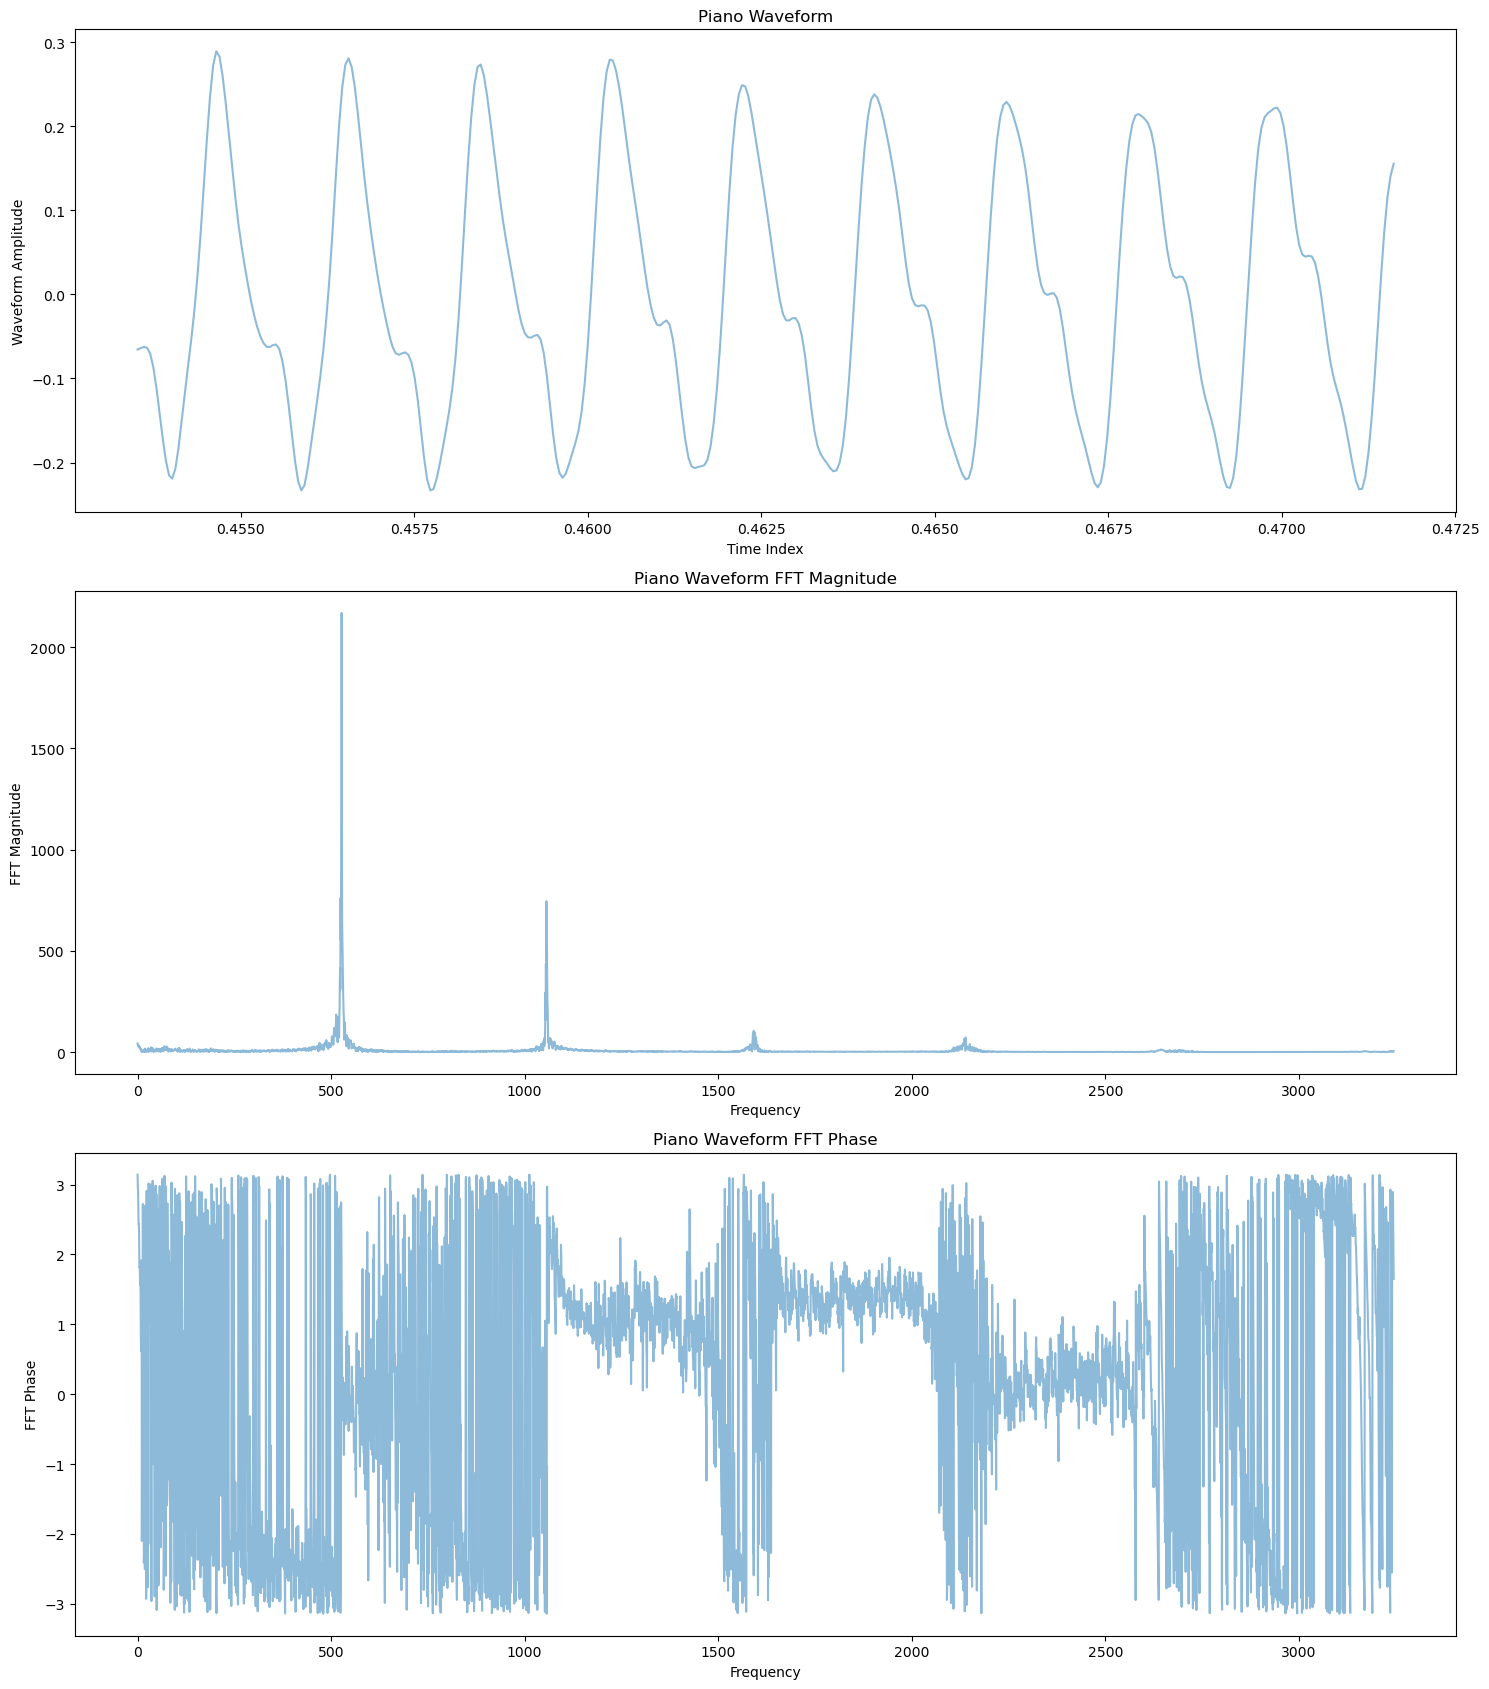

In [4]:
import matplotlib.pyplot as plt
alpha=0.5
L = y_piano_resampled_downmixed.size(-1)
t = torch.arange(L)/22050
f = torch.arange(L)/L*22050


plt.figure(figsize=(15, 17))
plt.subplot(3,1,1)
plt.plot(t[10000:10400], y_piano_resampled_downmixed[0, 10000:10400], label='audio', alpha=alpha)
plt.title("Piano Waveform")
plt.xlabel("Time Index")
plt.ylabel("Waveform Amplitude")

plt.subplot(3,1,2)
plt.plot(f[:5000], y_piano_fft_mag[0,:5000], label='fft', alpha=alpha)
plt.title("Piano Waveform FFT Magnitude")
plt.xlabel("Frequency")
plt.ylabel("FFT Magnitude")

plt.subplot(3,1,3)
plt.plot(f[:5000], y_piano_fft_phase[0,:5000], label='fft', alpha=alpha)
plt.title("Piano Waveform FFT Phase")
plt.xlabel("Frequency")
plt.ylabel("FFT Phase")
plt.tight_layout()
plt.show()

In [5]:
# Some observations are clear.
# FFT is symmetric. torch.fft.fft calculates for last dimension, 1D FFT. 

## Visualization with pure sinusoids

In [6]:
f = 523
T_f = 1/f   
print(T_f)   # around 2 ms

T = 1/22050
print(400 * T)  # Around 20 ms, so 10 cycles

0.0019120458891013384
0.018140589569160998


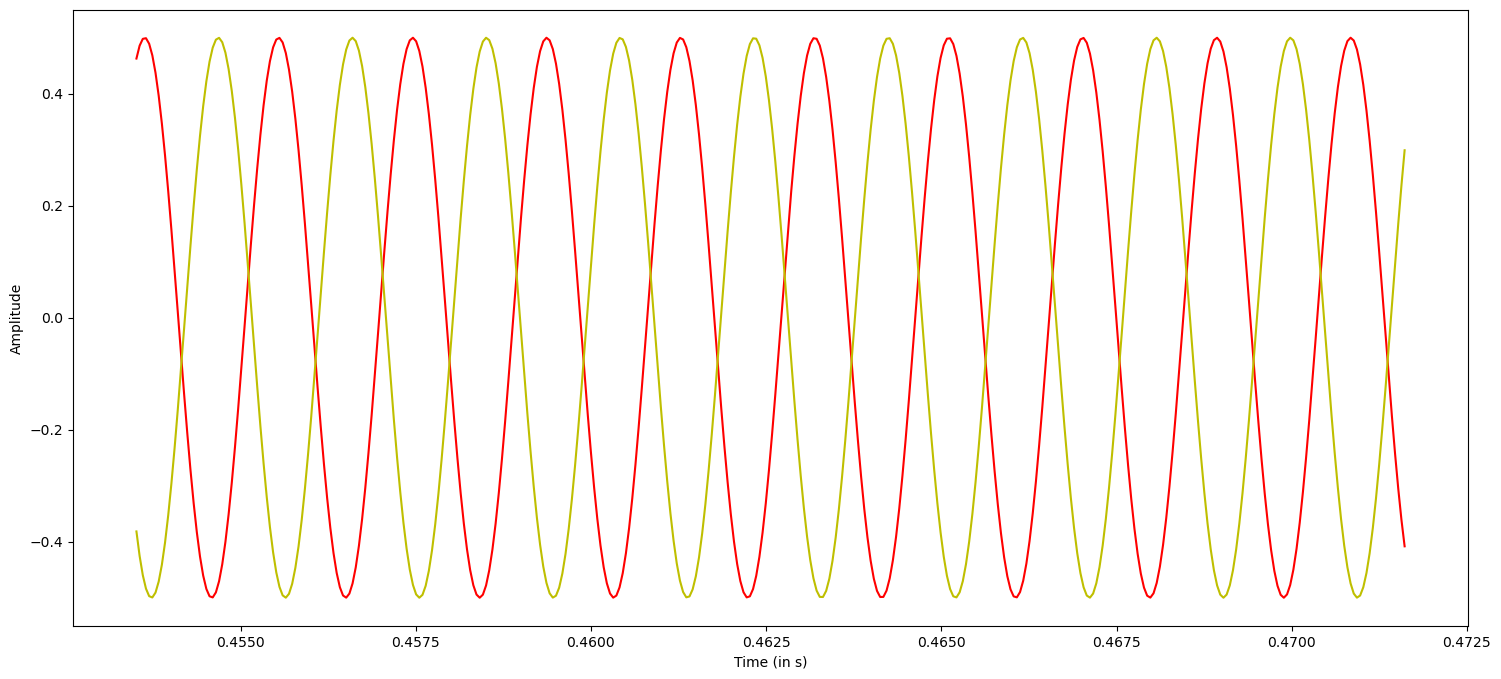

In [7]:
# A sinusoid of frequency 512 Hz for 10 cycles

f=523

phi1=0
phi2=0.55

sin1 = 0.5* torch.sin(2*torch.pi*(f*t-phi1))
sin2 = 0.5*torch.sin(2*torch.pi*(f*t-phi2))

plt.figure(figsize=(18,8))
plt.plot(t[10000:10400], sin1[10000:10400],color='r')
plt.plot(t[10000:10400], sin2[10000:10400],color='y')
plt.xlabel("Time (in s)")
plt.ylabel("Amplitude")
plt.show()

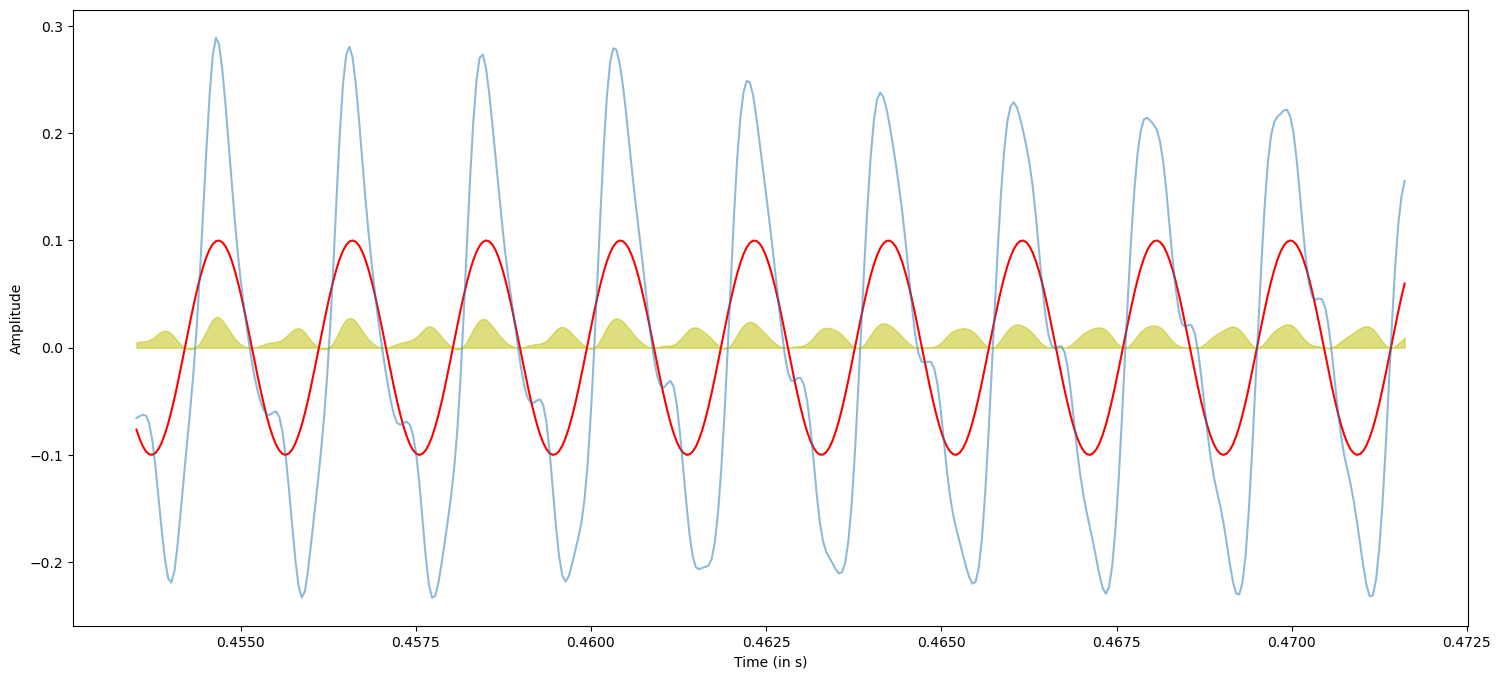

In [8]:
f=523

phi1=0.55

sin1 = 0.1* torch.sin(2*torch.pi*(f*t-phi1))

plt.figure(figsize=(18,8))
plt.plot(t[10000:10400], sin1[10000:10400],color='r')
plt.plot(t[10000:10400], y_piano_resampled_downmixed[0, 10000:10400], label='audio', alpha=alpha)
plt.fill_between(t[10000:10400], y_piano_resampled_downmixed[0, 10000:10400]*sin1[10000:10400], label='audio', alpha=alpha, color='y')
plt.xlabel("Time (in s)")
plt.ylabel("Amplitude")
plt.show()
